# Notebook pour wordToVec puis LSTM

## Importation des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split
import re
import torch.nn as nn

In [2]:
data = pd.read_csv("donnees/donnees_final_sans_doublons.csv")
data

,Label,Titre,Date
0,culture,Affaire Gérard Depardieu : le parquet de Paris...,2024-08-22T20:40:00+02:00
1,culture,"Festival de Deauville 2023 : avec ""Dogman"", Lu...",2023-09-03T12:06:33+02:00
2,culture,Haute couture,Date non trouvée
3,culture,Festival du livre de Paris 2024,Date non trouvée
4,culture,"""En live, le public doit s'amuser imméd...",2024-06-21T11:44:29+02:00
...,...,...,...
7021,sports,Ligue 1 : Lyon maîtrise Saint-Etienne dans le ...,2024-11-10T20:06:00+01:00
7022,sports,Football : le milieu de l'équipe de France You...,2024-08-17T17:00:55+02:00
7023,sports,Football : l'OM officialise l'arrivée d'Adrien...,2024-09-17T18:18:54+02:00
7024,sports,Ligue 1 : le match Nantes-Le Havre interrompu ...,2024-11-24T19:44:29+01:00


In [3]:
label_map = {"culture" :  0, "monde": 1, "meteo": 2, "sante": 3, "politique": 4, "societe": 5, "europe": 6, "environnement": 7, "sports": 8}
inv_label_map = {0: "culture", 1: "monde", 2: "meteo", 3: "sante", 4: "politique", 5: "societe", 6: "europe", 7: "environnement", 8: "sports"}
inv_label_map_to_keep = {0: "culture", 1: "monde", 2: "meteo", 3: "sante", 4: "politique", 5: "societe"}

# Conversion des étiquettes en indices numériques
labels_numeric = [label_map[label] for label in data['Label']]
print(len(labels_numeric))

7026


In [4]:
# Compter le nombre d'occurences de chaque étiquette
from collections import Counter
print(Counter(labels_numeric))

Counter({6: 814, 1: 807, 2: 803, 0: 792, 7: 767, 3: 764, 8: 763, 5: 760, 4: 756})


## Importation de l'embedding

In [5]:
from gensim.models import KeyedVectors

In [6]:
model = KeyedVectors.load_word2vec_format("frWac_no_postag_phrase_500_cbow_cut100.bin", binary=True, unicode_errors="ignore")


In [7]:
def vectorize_sentence(sentence, model, max_sequence_length=128):
    # Convertir la phrase en minuscules et supprimer les caractères spéciaux
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-z0-9\s]', ' ', sentence)
    
    # Séparer en mots
    words = sentence.split()
    word_vectors = []
    
    for word in words:
        if word in model.key_to_index:
            word_vectors.append(model[word])
        else:
            print(f"Le mot '{word}' n'est pas dans le vocabulaire du modèle.")
    
    # Si aucun mot valide n'a été trouvé, retourner un vecteur de zéros
    if not word_vectors:
        return np.zeros((max_sequence_length, model.vector_size), dtype=np.float32)
    
    # Convertir en numpy array pour faciliter le padding
    word_vectors = np.array(word_vectors)

    # Appliquer le padding ou tronquer pour atteindre la taille max_sequence_length
    if word_vectors.shape[0] < max_sequence_length:
        # Ajouter des vecteurs de zéros si la phrase est plus courte que la longueur maximale
        padding = np.zeros((max_sequence_length - word_vectors.shape[0], model.vector_size), dtype=np.float32)
        word_vectors = np.vstack([word_vectors, padding])
    else:
        # Tronquer si la phrase est trop longue
        word_vectors = word_vectors[:max_sequence_length]
    
    return word_vectors

## Preprocessing

In [8]:
def preprocess_texts(texts, blacklist_words, remove_random=False, random_fraction=0.1):
   
    cleaned_texts = []
    
    for text in texts:
        words = text.split()
        words = [word for word in words if word.lower() not in blacklist_words]
        
        if remove_random:
            num_to_remove = int(len(words) * random_fraction)
            words = [word for i, word in enumerate(words) if i not in random.sample(range(len(words)), num_to_remove)]
        
        cleaned_texts.append(' '.join(words))
    
    return cleaned_texts


# Exemple d'utilisation
blacklist_words = ["le", "la", "les", "un", "une", "et", "ou","l'","il"] 

# Nettoyer les titres
data['Titre_preprocess'] = preprocess_texts(
    data['Titre'].astype(str).tolist(), 
    blacklist_words=blacklist_words, 
    remove_random=True,  
    random_fraction=0.1
)


## Entrainement du model

In [9]:
data_sort = data[data['Date']!= "Date non trouvée"].sort_values(by='Date')


test_size = 0.1  
val_size = 0.2  

n_total = len(data_sort)
n_test = int(n_total * test_size)
n_train_val = n_total - n_test
n_val = int(n_train_val * val_size)

# Découper les ensembles
train_data = data_sort.iloc[:n_train_val - n_val]
val_data = data_sort.iloc[n_train_val - n_val:n_train_val]
test_data = data_sort.iloc[n_train_val:]

train_vectors = [vectorize_sentence(sentence, model) for sentence in train_data['Titre_preprocess']]
val_vectors = [vectorize_sentence(sentence, model) for sentence in val_data['Titre_preprocess']]
test_vectors = [vectorize_sentence(sentence, model) for sentence in test_data['Titre_preprocess']]
train_labels = [label_map[label] for label in train_data['Label']]
val_labels = [label_map[label] for label in val_data['Label']]
test_labels = [label_map[label] for label in test_data['Label']]
print(len(train_vectors), len(val_vectors), len(test_vectors))

# Convertir les labels en tensor
train_labels_tensor = torch.tensor(train_labels)
test_labels_tensor = torch.tensor(test_labels)
train_vectors_tensor = torch.tensor(train_vectors)
test_vectors_tensor = torch.tensor(test_vectors)
val_labels_tensor = torch.tensor(val_labels)
val_vectors_tensor = torch.tensor(val_vectors)


# Créer des TensorDatasets pour l'entraînement et la validation
train_dataset = TensorDataset(
    train_vectors_tensor,
    train_labels_tensor
)

test_dataset = TensorDataset(
    test_vectors_tensor,
    test_labels_tensor
)

val_dataset = TensorDataset(
    val_vectors_tensor,
    val_labels_tensor
)

# Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)

print(len(train_dataloader), len(test_dataloader), len(val_dataloader))

Le mot 'encercl' n'est pas dans le vocabulaire du modèle.
Le mot 'au' n'est pas dans le vocabulaire du modèle.
Le mot 'plut' n'est pas dans le vocabulaire du modèle.
Le mot '80' n'est pas dans le vocabulaire du modèle.
Le mot '10' n'est pas dans le vocabulaire du modèle.
Le mot 'du' n'est pas dans le vocabulaire du modèle.
Le mot 'conna' n'est pas dans le vocabulaire du modèle.
Le mot 'infographies' n'est pas dans le vocabulaire du modèle.
Le mot 'timents' n'est pas dans le vocabulaire du modèle.
Le mot 'occup' n'est pas dans le vocabulaire du modèle.
Le mot 'explosive' n'est pas dans le vocabulaire du modèle.
Le mot 'russes' n'est pas dans le vocabulaire du modèle.
Le mot 'encerclent' n'est pas dans le vocabulaire du modèle.
Le mot 'ukrainiennes' n'est pas dans le vocabulaire du modèle.
Le mot 'ingmar' n'est pas dans le vocabulaire du modèle.
Le mot 'au' n'est pas dans le vocabulaire du modèle.
Le mot 'rendum' n'est pas dans le vocabulaire du modèle.
Le mot 'ripostent' n'est pas dans 

/tmp/ipykernel_6161/2962590034.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/torch/csrc/utils/tensor_new.cpp:261.)
  train_vectors_tensor = torch.tensor(train_vectors)


In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Définir l'architecture de l'LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Batch Normalization
        self.batch_norm = nn.BatchNorm1d(hidden_size)

        # Activation
        self.relu = nn.ReLU()

        # Couche de classification (fully connected layer)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        output, _ = self.lstm(x)
        output = output[:, -1, :]
        output = self.batch_norm(output)
        output = self.relu(output)
        output = self.fc(output)
        return output

In [13]:
input_size = 500
hidden_size = 512
num_layers = 4
num_classes = 9

# Définir le modèle
model = LSTM(input_size, hidden_size, num_layers, num_classes)
model

LSTM(
  (lstm): LSTM(500, 512, num_layers=4, batch_first=True)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc): Linear(in_features=512, out_features=9, bias=True)
)

---->  cuda
Epoch [1/20], Train Loss: 2.1888, Validation Loss: 2.6654
Epoch [2/20], Train Loss: 2.1728, Validation Loss: 36.6600
Epoch [3/20], Train Loss: 2.2271, Validation Loss: 2.4086
Epoch [4/20], Train Loss: 2.0702, Validation Loss: 2.2597
Epoch [5/20], Train Loss: 1.9623, Validation Loss: 3.4442
Epoch [6/20], Train Loss: 1.7455, Validation Loss: 7.3419
Epoch [7/20], Train Loss: 1.5990, Validation Loss: 5.8299
Epoch [8/20], Train Loss: 1.3951, Validation Loss: 5.8275
Epoch [9/20], Train Loss: 1.0799, Validation Loss: 14.0016
Epoch [10/20], Train Loss: 0.7201, Validation Loss: 6.7676
Epoch [11/20], Train Loss: 0.4497, Validation Loss: 1.7940
Epoch [12/20], Train Loss: 0.3122, Validation Loss: 2.4293
Epoch [13/20], Train Loss: 0.2363, Validation Loss: 1.6211
Epoch [14/20], Train Loss: 0.1748, Validation Loss: 1.6964
Epoch [15/20], Train Loss: 0.1310, Validation Loss: 1.7834
Epoch [16/20], Train Loss: 0.1101, Validation Loss: 2.0180
Epoch [17/20], Train Loss: 0.0975, Validation Loss:

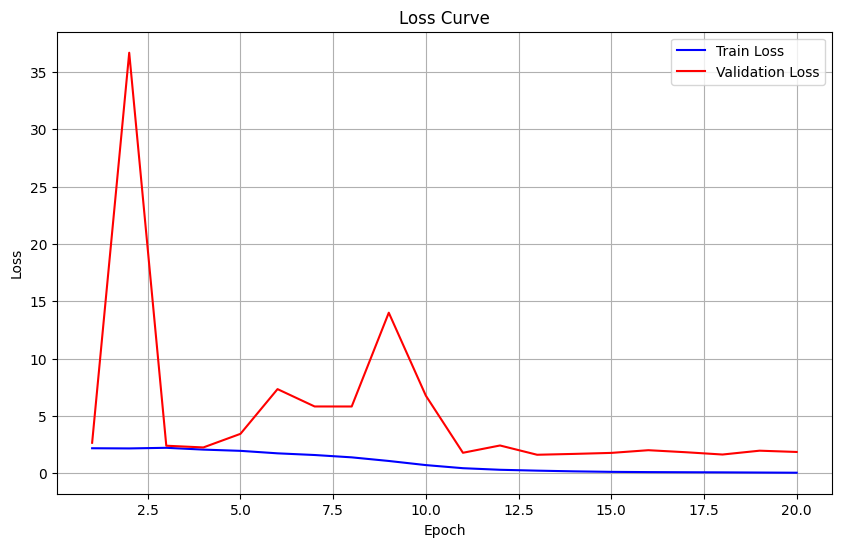

In [14]:
import torch.nn.functional as F

# Optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("----> ", device)
model.to(device)
model.train()
# Variables pour stocker les pertes
train_losses = []
val_losses = []

# Nombre d'époques
nb_epoch = 20

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

# Boucle d'entraînement
for epoch in range(nb_epoch):
    
    # Phase d'entraînement
    model.train()
    total_train_loss = 0

    for batch in train_dataloader:
        vectors, label = batch
        vectors = vectors.to(device)
        label = label.to(device)

        # Propagation avant (forward pass)
        outputs = model(vectors)
        
        loss = F.cross_entropy(outputs, label)
        
        # Rétropropagation (backpropagation)
        loss.backward()

        # Clip des gradients pour éviter l'explosion du gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Optimisation des paramètres du modèle
        optimizer.step()
        optimizer.zero_grad()
        
        # Ajouter la perte de ce batch à la perte totale
        total_train_loss += loss.item()

    # Calcul de la perte moyenne pour l'entraînement
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Phase de validation
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad(): 
        for batch in val_dataloader:
            vectors, label = batch
            vectors = vectors.to(device)
            label = label.to(device)

            # Propagation avant (forward pass)
            outputs = model(vectors)
            
            # La perte de validation
            val_loss = F.cross_entropy(outputs, label)
            total_val_loss += val_loss.item()

    # Calcul de la perte moyenne pour la validation
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss) 

    # Affichage de la perte de validation
    print(f"Epoch [{epoch+1}/{nb_epoch}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

# Affichage des courbes de perte d'entraînement et de validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, nb_epoch + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, nb_epoch + 1), val_losses, label='Validation Loss', color='red')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Validation du model

Validation Loss: 1.7402262687683105


<Figure size 2000x2000 with 0 Axes>

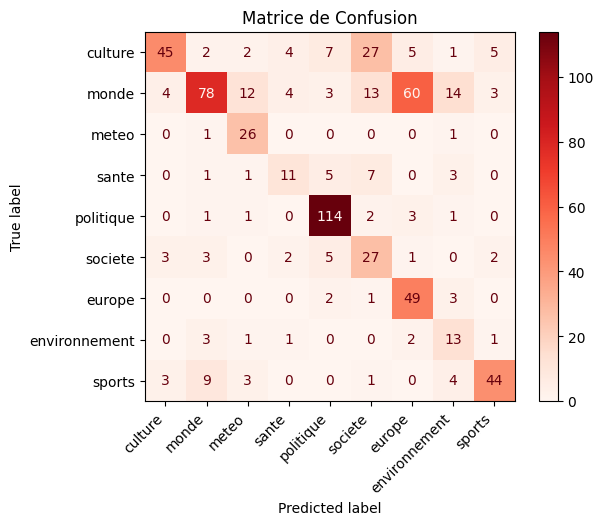

In [15]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()

all_predictions = []
all_labels = []

test_loss = 0

    
with torch.no_grad(): 
    for batch in test_dataloader:
        vectors, labels = batch
        vectors = vectors.to(device)
        labels = labels.to(device)

        # Propagation avant (forward pass)
        outputs = model(vectors)
            
        # La perte de validation
        test_loss += F.cross_entropy(outputs, labels)

        predictions = torch.argmax(outputs, dim=1)
    
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_dataloader)
print(f"Validation Loss: {test_loss}")
all_labels_name = [inv_label_map[x] for x in all_labels]
all_predictions_name = [inv_label_map[x] for x in all_predictions]

cm = confusion_matrix(all_labels, all_predictions)

# Assurez-vous que le nombre d'étiquettes ici correspond à vos 9 labels dans inv_label_map
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[inv_label_map[i] for i in range(9)])
plt.figure(figsize=(20, 20))
display.plot(cmap=plt.cm.Reds)
plt.title("Matrice de Confusion")
plt.xticks(rotation=45, ha="right")
plt.show()


In [16]:
from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score

def calculate_metrics(labels, predictions):
    metrics = {}
    metrics['accuracy'] = accuracy_score(labels, predictions)
    metrics['precision'] = precision_score(labels, predictions, average='weighted')
    metrics['recall'] = recall_score(labels, predictions, average='weighted')
    metrics['f0.5_score'] = fbeta_score(labels, predictions, beta=0.5, average='weighted')
    metrics['f2_score'] = fbeta_score(labels, predictions, beta=2, average='weighted')
    metrics['f1_score'] = fbeta_score(labels, predictions, beta=1, average='weighted')
    
    return metrics

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
import numpy as np
import matplotlib.pyplot as plt

def calculate_classwise_metrics(labels, predictions):
    
    metrics_per_class = {}
    
    for class_index, class_name in inv_label_map.items():
        class_labels = [1 if label == class_index else 0 for label in labels]
        class_predictions = [1 if pred == class_index else 0 for pred in predictions]
        
        metrics_per_class[class_name] = {
            'accuracy': accuracy_score(class_labels, class_predictions),
            'precision': precision_score(class_labels, class_predictions, zero_division=0),
            'recall': recall_score(class_labels, class_predictions, zero_division=0),
            'f1_score': fbeta_score(class_labels, class_predictions, beta=1, zero_division=0),
            'f0.5_score': fbeta_score(class_labels, class_predictions, beta=0.5, zero_division=0),
            'f2_score': fbeta_score(class_labels, class_predictions, beta=2, zero_division=0)
        }
    
    return metrics_per_class

def display_classwise_metrics(metrics_per_class):
    
    class_names = list(metrics_per_class.keys())
    metric_names = ['accuracy', 'precision', 'recall', 'f1_score', 'f0.5_score', 'f2_score']
    
    donnees = np.array([[metrics_per_class[cls][metric] for metric in metric_names] for cls in class_names])
    num_classes, num_metrics = donnees.shape
    
    x = np.arange(num_metrics) 
    width = 0.15 
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for i in range(num_classes):
        ax.bar(x + i * width, donnees[i], width, label=class_names[i])
    
    ax.set_title("Métriques par Classe", fontsize=16)
    ax.set_xticks(x + width * (num_classes - 1) / 2)
    ax.set_xticklabels(metric_names, fontsize=12)
    ax.set_ylabel("Score", fontsize=14)
    ax.set_ylim(0, 1)  
    ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


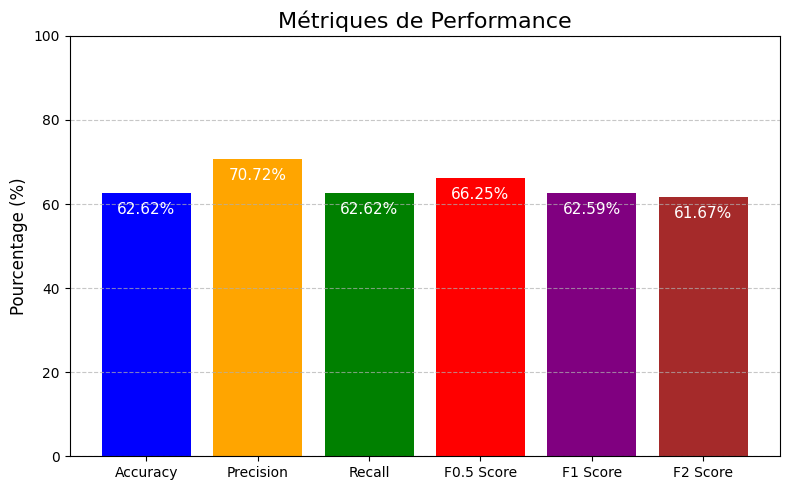

In [18]:
metrics = calculate_metrics(all_labels, all_predictions)

metric_names = ['Accuracy', 'Precision', 'Recall', 'F0.5 Score', 'F1 Score', 'F2 Score']
metric_values = [
    metrics['accuracy'] * 100,
    metrics['precision'] * 100,
    metrics['recall'] * 100,
    metrics['f0.5_score'] * 100,
    metrics['f1_score'] * 100,
    metrics['f2_score'] * 100
]

plt.figure(figsize=(8, 5))
bars = plt.bar(metric_names, metric_values, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
for bar, value in zip(bars, metric_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5,
             f"{value:.2f}%", ha='center', color='white', fontsize=11)

plt.title("Métriques de Performance", fontsize=16)
plt.ylabel("Pourcentage (%)", fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()